In [1]:
import pandas as pd
import numpy as np
import os

# === RUTAS ===
IN_PARQUET = "resilience/windows.parquet"   # si no existe, lee CSV fallback
OUT_PARQUET = "resilience/windows_with_RI.parquet"

In [2]:
# === CARGA ===
if os.path.exists(IN_PARQUET):
    df = pd.read_parquet(IN_PARQUET)
elif os.path.exists(IN_PARQUET.replace(".parquet", ".csv")):
    df = pd.read_csv(IN_PARQUET.replace(".parquet", ".csv"))
else:
    raise FileNotFoundError("No encontré ni resilience/windows.parquet ni resilience/windows.csv")


In [4]:
# columnas meta que no entrenamos
META_COLS = ["t_start_idx", "t_end_idx"]

X_df = df.drop(columns=[c for c in META_COLS if c in df.columns]).copy()

X_df = X_df.apply(pd.to_numeric, errors="coerce")   # => convierte no-numéricos a NaN
X_df = X_df.astype("float32")                       # => usa NumPy float32 (evita Float64Dtype)
X_df = X_df.fillna(0.0)                             # => sin NaNs

In [7]:
print("shape features:", X_df.shape)
X_df.head()

shape features: (243, 16)


,h2_served_MWh,h2_unmet_proxy,soc_min,soc_p50,soc_p95,h2_produced_MWh,elec_to_e_MWh,water_to_e_units,sp_h2_MWh_per_MWh_elec,water_per_MWh_h2,cf_electrolyzer_approx,cap_pv_MW,cap_el_MW,cap_line_MW,cap_h2_store_MWh,total_cost
0,0.647712,0.0,0.0,346.436493,851.388977,0.649495,0.95514,4416.659668,0.68,0.397059,0.216498,0.046071,0.017857,0.055285,0.080377,260902848.0
1,0.647712,0.0,0.0,346.436493,851.388977,0.649495,0.95514,4416.659668,0.68,0.397059,0.216498,0.046071,0.017857,0.055285,0.080377,260902848.0
2,0.647712,0.0,0.0,346.436493,851.388977,0.649495,0.95514,4416.659668,0.68,0.397059,0.216498,0.046071,0.017857,0.055285,0.080377,260902848.0
3,0.647712,0.0,0.0,346.436493,851.388977,0.649495,0.95514,4416.659668,0.68,0.397059,0.216498,0.046071,0.017857,0.055285,0.080377,260902848.0
4,0.647712,0.0,0.0,346.436493,851.388977,0.649495,0.95514,4416.659668,0.68,0.397059,0.216498,0.046071,0.017857,0.055285,0.080377,260902848.0


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# === Tensores ===
X = torch.tensor(X_df.values, dtype=torch.float32)
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

In [9]:
# === Modelo ===
class AE(nn.Module):
    def __init__(self, d_in, d_lat=4):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 256), nn.ReLU(),
            nn.Linear(256, 64), nn.ReLU(),
            nn.Linear(64, d_lat),
        )
        self.dec = nn.Sequential(
            nn.Linear(d_lat, 64), nn.ReLU(),
            nn.Linear(64, 256), nn.ReLU(),
            nn.Linear(256, d_in),
        )
    def forward(self, x):
        z = self.enc(x)
        xhat = self.dec(z)
        return xhat, z

In [10]:

d_in = X.shape[1]
d_lat = 4    # puedes subir a 6–8 si tienes más features
epochs = 60

ae = AE(d_in, d_lat)
opt = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

ae.train()
for ep in range(epochs):
    running = 0.0
    for (xb,) in loader:
        xhat, _ = ae(xb)
        loss = loss_fn(xhat, xb)
        opt.zero_grad(); loss.backward(); opt.step()
        running += float(loss.item()) * xb.size(0)
    if (ep+1) % 10 == 0:
        print(f"[ep {ep+1}] recon_loss={running/len(X):.6f}")


[ep 10] recon_loss=3827445073444864.000000
[ep 20] recon_loss=1761066379902976.000000
[ep 30] recon_loss=350547177635840.000000
[ep 40] recon_loss=30949083447296.000000
[ep 50] recon_loss=22186502914048.000000
[ep 60] recon_loss=21690838941696.000000


In [11]:
# embeddings + error
ae.eval()
with torch.no_grad():
    Xhat, Z = ae(X)
recon_err = ((Xhat - X)**2).mean(dim=1).cpu().numpy()
Z = Z.cpu().numpy()

print("latent shape:", Z.shape, "| recon_err mediana:", np.median(recon_err))

latent shape: (243, 4) | recon_err mediana: 14682554000000.0


In [12]:
# --- Proxy de ventanas resilientes para anclar el "centro resiliente"
# Criterio simple: buena cobertura (h2_served alta), buen colchón (soc_min alto), bajo "unmet"
def build_proxy_resilient_mask(df_):
    cond_serv = df_["h2_served_MWh"] >= df_["h2_served_MWh"].quantile(0.5) if "h2_served_MWh" in df_ else True
    cond_soc  = df_["soc_min"]       >= df_["soc_min"].quantile(0.5)       if "soc_min" in df_ else True
    cond_unmet= df_["h2_unmet_proxy"]<= df_["h2_unmet_proxy"].quantile(0.5)if "h2_unmet_proxy" in df_ else True
    return (cond_serv & cond_soc & cond_unmet).values

mask_res = build_proxy_resilient_mask(df)

# --- Cálculo RI (0–100)
med_err = np.median(recon_err) + 1e-9
err_norm = recon_err / med_err

if mask_res.sum() == 0:
    # sin proxy → usar sólo reconstrucción
    RI = 100.0 * (1.0 - np.clip(err_norm, 0, 1))
else:
    mu = Z[mask_res].mean(axis=0)
    dist = np.linalg.norm(Z - mu, axis=1)
    dist_norm = dist / (np.median(dist) + 1e-9)
    RI = 100.0 * np.exp(-dist_norm) * (1.0 - np.clip(err_norm, 0, 1))

# --- Empaquetar salida
out = df.copy()
for i in range(Z.shape[1]):
    out[f"z_{i}"] = Z[:, i]
out["recon_err"] = recon_err
out["RI_0_100"]  = RI

# Guardar
os.makedirs(os.path.dirname(OUT_PARQUET), exist_ok=True)
try:
    out.to_parquet(OUT_PARQUET, index=False)
    print(f"[OK] Guardado {OUT_PARQUET} | shape={out.shape}")
except Exception as e:
    alt_csv = OUT_PARQUET.replace(".parquet", ".csv")
    out.to_csv(alt_csv, index=False)
    print(f"[WARN] Parquet falló ({e}). Guardé CSV en {alt_csv}")

# vistazo rápido
out[["t_start_idx","t_end_idx","RI_0_100","recon_err"] + [c for c in out.columns if c.startswith("z_")]].head()


[OK] Guardado resilience/windows_with_RI.parquet | shape=(243, 24)


,t_start_idx,t_end_idx,RI_0_100,recon_err,z_0,z_1,z_2,z_3
0,0,168,0.000511,1.468222e+13,115669000.0,-58327020.0,82801296.0,2221578.0
1,72,240,0.000511,1.468222e+13,115669000.0,-58327020.0,82801296.0,2221578.0
2,144,312,0.000511,1.468222e+13,115669000.0,-58327020.0,82801296.0,2221578.0
3,216,384,0.000511,1.468222e+13,115669000.0,-58327020.0,82801296.0,2221578.0
4,288,456,0.000511,1.468222e+13,115669000.0,-58327020.0,82801296.0,2221578.0


In [13]:
out = pd.read_parquet("resilience/windows_with_RI.parquet")
print(out.shape, out.columns.tolist())

# Top 10 más resilientes y 10 menos resilientes
top10 = out.sort_values("RI_0_100", ascending=False).head(10)
bot10 = out.sort_values("RI_0_100", ascending=True).head(10)

top10[["t_start_idx","t_end_idx","RI_0_100","recon_err"]].style.background_gradient(subset=["RI_0_100"])
bot10[["t_start_idx","t_end_idx","RI_0_100","recon_err"]].style.background_gradient(subset=["RI_0_100"])

(243, 24) ['h2_served_MWh', 'h2_unmet_proxy', 'soc_min', 'soc_p50', 'soc_p95', 'h2_produced_MWh', 'elec_to_e_MWh', 'water_to_e_units', 'sp_h2_MWh_per_MWh_elec', 'water_per_MWh_h2', 'cf_electrolyzer_approx', 'cap_pv_MW', 'cap_el_MW', 'cap_line_MW', 'cap_h2_store_MWh', 'total_cost', 't_start_idx', 't_end_idx', 'z_0', 'z_1', 'z_2', 'z_3', 'recon_err', 'RI_0_100']


,t_start_idx,t_end_idx,RI_0_100,recon_err
127,9144,9312,0.000000,14682904592384.000000
126,9072,9240,0.000000,14682904592384.000000
123,8856,9024,0.000000,14682904592384.000000
121,8712,8880,0.000000,14682554368000.000000
124,8928,9096,0.000000,14682904592384.000000
125,9000,9168,0.000000,14682904592384.000000
122,8784,8952,0.000000,14682904592384.000000
184,13248,13416,0.000000,14682904592384.000000
183,13176,13344,0.000000,14682904592384.000000
182,13104,13272,0.000000,14682904592384.000000


In [14]:
cand = ["RI_0_100","recon_err","h2_served_MWh","soc_min","h2_unmet_proxy","cf_electrolyzer_approx"]
corr = out[[c for c in cand if c in out.columns]].corr()
corr


,RI_0_100,recon_err,h2_served_MWh,soc_min,h2_unmet_proxy,cf_electrolyzer_approx
RI_0_100,1.000000,-0.997643,-0.998474,NaN,NaN,-0.998781
recon_err,-0.997643,1.000000,0.999749,NaN,NaN,0.999711
h2_served_MWh,-0.998474,0.999749,1.000000,NaN,NaN,0.999948
soc_min,NaN,NaN,NaN,NaN,NaN,NaN
h2_unmet_proxy,NaN,NaN,NaN,NaN,NaN,NaN
cf_electrolyzer_approx,-0.998781,0.999711,0.999948,NaN,NaN,1.000000


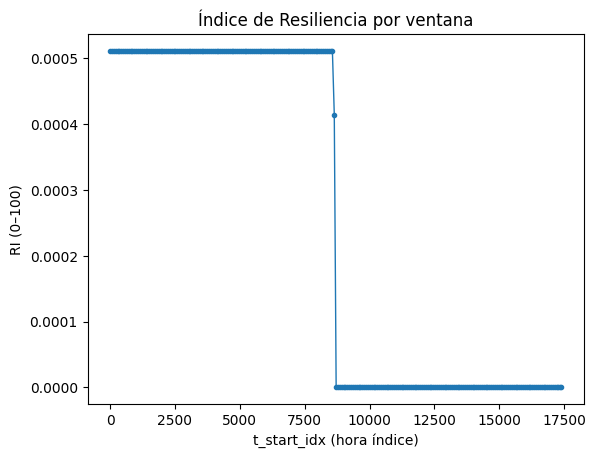

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(out["t_start_idx"], out["RI_0_100"], marker=".", linewidth=1)
plt.xlabel("t_start_idx (hora índice)"); plt.ylabel("RI (0–100)"); plt.title("Índice de Resiliencia por ventana")
plt.show()


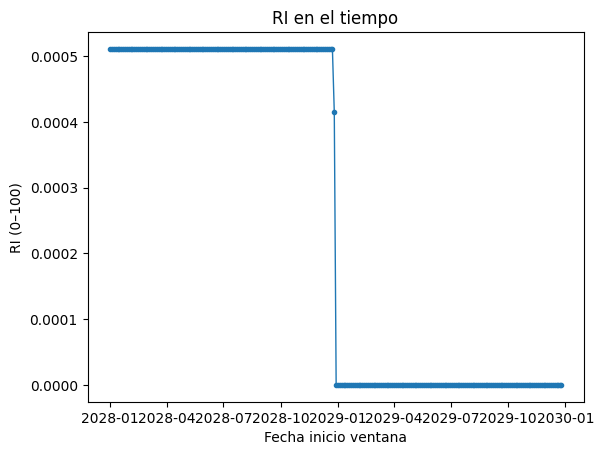

In [16]:
import xarray as xr
ds = xr.load_dataset("results_baseline_2028_tx.nc")
time = pd.to_datetime(ds["timesteps"].values)

out["t_start_ts"] = time[out["t_start_idx"].clip(0, len(time)-1).astype(int).values]
out["t_end_ts"]   = time[(out["t_end_idx"]-1).clip(0, len(time)-1).astype(int).values]

# Gráfico ahora con fechas reales:
plt.figure()
plt.plot(out["t_start_ts"], out["RI_0_100"], marker=".", linewidth=1)
plt.xlabel("Fecha inicio ventana"); plt.ylabel("RI (0–100)"); plt.title("RI en el tiempo")
plt.show()

# Guarda versión enriquecida
out.to_parquet("resilience/windows_with_RI_and_time.parquet", index=False)


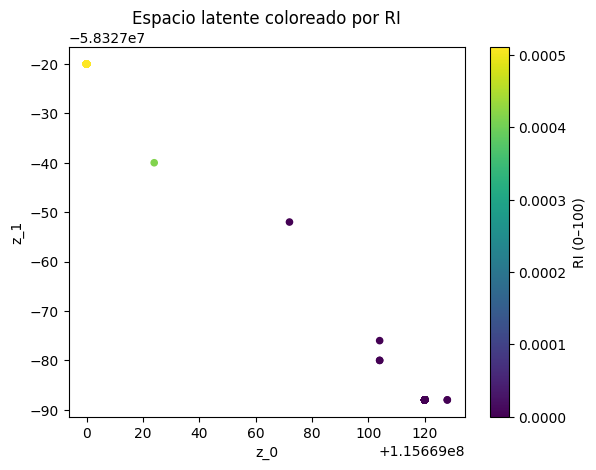

In [17]:
import matplotlib.pyplot as plt

cols_z = [c for c in out.columns if c.startswith("z_")]
assert len(cols_z) >= 2, "Tu latente tiene <2 dims; sube d_lat a >=2."
plt.figure()
sc = plt.scatter(out[cols_z[0]], out[cols_z[1]], c=out["RI_0_100"], s=20)
plt.xlabel(cols_z[0]); plt.ylabel(cols_z[1]); plt.title("Espacio latente coloreado por RI")
plt.colorbar(sc, label="RI (0–100)")
plt.show()
